# FIT5202 Data processing for Big data

##  Assignment 2A: Building models to predict pedestrian traffic

Author: **Akash Goyal**<br>
Date: **31-01-2021**

<br>

## Table of Contents

* [Libraries used](#lib)
* [Introduction](#intro)
* [1. Data Loading and Exploration](#one)
    * [1.1 Data Loading](#1.1)
        * [Part 1.1.1](#1.1.1)
        * [Part 1.1.2](#1.1.2)
        * [Part 1.1.3](#1.1.3)
        * [Part 1.1.4](#1.1.4)
    * [1.2 Exploring the data](#1.2)
        * [Part 1.2.1](#1.2.1)
        * [Part 1.2.2](#1.2.2)
        * [Part 1.2.3](#1.2.3)
        * [Part 1.2.4](#1.2.4)
* [2. Feature extraction and ML training](#two)
    * [2.1 Discuss the feature selection and prepare the feature columns](#2.1)
        * [Part 2.1.1](#2.1.1)
        * [Part 2.1.2](#2.1.2)
    * [2.2 Preparing Spark ML Transformers/Estimators for features, labels and models](#2.2)
        * [Part 2.2.1](#2.2.1)
        * [Part 2.2.2](#2.2.2)
        * [Part 2.2.3](#2.2.3)
    * [2.3 Preparing the training data and testing data](#2.3)
        * [Part 2.3.1](#2.3.1)
    * [2.4 Training and evaluating models](#2.4)
        * [Usecase-1](#u1)
            * [Part 2.4.1](#2.4.1)
            * [Part 2.4.2](#2.4.2)
            * [Part 2.4.3](#2.4.3)
            * [Part 2.4.4](#2.4.4)
        * [Usecase-2](#u2)
            * [Part 2.4.5](#2.4.5)
            * [Part 2.4.6](#2.4.6)
* [3. Performance comparison](#three)
    * [3.1 KMeans Clustering](#3.1)
    * [3.2 Parallelism Theory Analysis](#3.2)

## Libraries used <a class="anchor" name="lib"></a>

This section contains all the libraries that would be needed to complete this assignment

In [64]:
# Import SparkConf class into program
from pyspark import SparkConf

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Libraries or visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For peforming regex operations
import re

# This part will install the seaborn package if there is an error 
try:
    import seaborn as sns
except:
    !pip install seaborn

# To be able to use the sql functions
from pyspark.sql.functions import *

# To be able to use windowing functions on Pyspark Dataframe
from pyspark.sql.window import Window as w

# Spark Datatypes in order to creating schema for Spark DataFrame
from pyspark.sql.types import TimestampType
from pyspark.sql.types import DateType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StructType
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructField

# For Modelling
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.regression import GBTRegressor

# To get the evaluation metrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

## Introduction <a class="anchor" name="intro"></a>

This assignment deals with the exploration of the pedestrian count open data form the City of Melbourne. As the data is huge there will be a need to use the big data tools to analyze it in an efficient manner. We will use the Pyspark's Dataframe and MLLib APIs to perform analysis and modelling to predict the required data.

## 1.Data Loading and exploration <a class="anchor" name="one"></a>

In this section we will perform the analysis using the RDDs.

## 1.1 Data Loading <a class="anchor" name="1.1"></a>

## Part 1.1.1 <a class="anchor" name="1.1.1"></a>

In this section we were required to create the spark context from the Spark Session. So in the below code it can be seen that the first the configurations for the spark sessionobject has been created. The configurations that have been set here are:
* The number of cores/processors that we want to use. This is set in a **master** variable. In the below case **local[\*]** has been used which means that all the processors that are there in the machine need to be used.
* Next we need to set the appropriate application name.

Using the above configuration values we can create a spark session object. But it is also required to set the UTC time-zone. To set this we need to make changes to the property **spark.sql.session.timeZone**. We need to set 'UTC' to the property as shown in the code below.

After this finally the spark context object can be created and then the log level can be set to **ERROR** so that not a lot of log generation takes place.

In [65]:
# For selecting all the cores in the machine
master = "local[*]"

# Putting the Application name
app_name = "Assignment2A-Building models to predict pedestrian traffic"

# Setting up the configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).config('spark.sql.session.timeZone', 'UTC').getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## Part 1.1.2 <a class="anchor" name="1.1.2"></a>

In this part of the assignment it is required to load the given data in 2 CSV files into Spark DataFrames with appropriate schema as given in the metadata file.

For this first we need to create the schema according to the metadata file with the exception of **location** column in the pedestrian data file. The schema can be created using the **StructType()** and the **StructField()** functions.
the complete schema for each dataframe would be created inside the StructType() function and to add a new field and its datatype the StructField datatype is used.

Below is the schema for the pedestrian and sensor data with the appropriate datatypes as mentioned in the metadata file.

In [66]:
# Schema for the pedestrian data
schema_pdstrn_count_df = StructType([
    StructField("ID", IntegerType()),
    StructField("Date_Time", TimestampType()),
    StructField("Year", IntegerType()),
    StructField("Month", StringType()),
    StructField("Mdate", IntegerType()),
    StructField("Day", StringType()),
    StructField("Time", IntegerType()),
    StructField("Sensor_ID", IntegerType()),
    StructField("Sensor_Name", StringType()),
    StructField("Hourly_Counts", IntegerType())
])

# Schema for the sensor data
schema_sensor_data_df = StructType([
    StructField("sensor_id", IntegerType()),
    StructField("sensor_description", StringType()),
    StructField("sensor_name", StringType()),
    StructField("installation_date", DateType()),
    StructField("status", StringType()),
    StructField("note", StringType()),
    StructField("direction_1", StringType()),
    StructField("direction_2", StringType()),
    StructField("latitude", FloatType()),
    StructField("longitude", FloatType()),
    StructField("location", StringType())
])


## Part 1.1.3 <a class="anchor" name="1.1.3"></a>

Now that the schema has been created for the pedestrian data, the dataframe can be created. For this we will use Spark's **read.csv()** function, which will take the **file location, header and schema** as parameters. The header parameter can be provided with **'true'** value as the header is present in the data.

The **option()** function has been used:
* To make sure the first row is read as header
* " character is escaped while parsing
* To parse the timestamp column while loading the file itself.

In [67]:
# Loading the pedestrian data
pdstrn_count_spdf = spark.read.format('csv').schema(schema_pdstrn_count_df)\
                         .option('header',True).option('escape','"').option("timestampFormat",'MM/dd/yyyy hh:mm:ss a')\
                         .load('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv')

Now that the schema has been created for the sensor data, the dataframe can be created. For this we will use Spark's **read.csv()** function, which will take the **file location, header and schema** as parameters. The header parameter can be provided with **'true'** value as the header is present in the data.

The **option()** function has been used:
* To make sure the first row is read as header
* " character is escaped while parsing
* To parse the date column while loading the file itself.

In [68]:
# Loading the sensor data
sensor_spdf = spark.read.format('csv').schema(schema_sensor_data_df)\
                         .option('header',True).option('escape','"').option("dateFormat",'yyyy/MM/dd')\
                         .load('Pedestrian_Counting_System_-_Sensor_Locations.csv')

In [69]:
# Displaying the schema for pedestrian data
pdstrn_count_spdf.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



In [70]:
# Displaying the schema for sensor data
sensor_spdf.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)



## Part 1.1.4 <a class="anchor" name="1.1.4"></a>

In this part the **above_threshold** column needs to be added. If the value of Hourly_Counts column would be above 2000 then the value will be '1' else it will be '0'. The column has been given string values purposefully, so that later it can be string indexed and proper process can be followed.

In [71]:
# Adding the column above_threshold which has the labels '0' and '1'
# String '0' and '1' has been purposefully used here
pdstrn_count_spdf = pdstrn_count_spdf.withColumn('above_threshold',when(col("Hourly_Counts") >= 2000, '1').otherwise('0'))

In [72]:
pdstrn_count_spdf.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)
 |-- above_threshold: string (nullable = false)



Seeing the above schema of the dataframe it can be easily seen that the **above_thresold** column has been successfully added.

## 1.2 Exploring the data <a class="anchor" name="1.2"></a>

In this part of the assignment we will explore the data so that we understand the crux of the data and are able to analyse it properly. Also, this exploration might help us to identify important features which can further be used to prepare the prediction model.

## Part 1.2.1 <a class="anchor" name="1.2.1"></a>

The first thing to do to understand the data is to see the summary of the data. The summary would tell us the basics of the data like:
* The count of the rows where the data is not null.
* The mean of the values of the columns.
* The standard deviation value of the respective columns.
* The minimum and maximum value of the column
* The 25, 50, 75 percentile values for the respective columns.

The summary for all the columns needs to be generated except for above_threshold and Date_Time column.

**Note: The ID column would also not be available in the summary as we aggregated the data earlier and laso the ID column does not contain any useful information as it will be unique for each row.**

The summary for the dataframe is being displayed using the below function **get_summary_stats()**.

In [73]:
def get_summary_stats(input_df):
    '''
    This function is used to display the summary as required in the question.
    The input params:
    1. input_df - Input dataframe whose summary needs to be found
    '''
    
    # Getting the summary for the integer or float columnsfor the input datafame using the summary()
    # function
    input_df.select(*[item[0] for item in pdstrn_count_spdf.dtypes \
                      if (item[1].startswith('int') or item[1].startswith('float'))])\
                        .summary().show()
    

In [74]:
get_summary_stats(pdstrn_count_spdf)

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|               ID|              Year|             Mdate|              Time|         Sensor_ID|    Hourly_Counts|
+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          3435106|           3435106|           3435106|           3435106|           3435106|          3435106|
|   mean|        1717553.5|2016.0032330880038|15.751918863639142|11.459955238644746|22.978422791028866|560.7805942524044|
| stddev|991629.8312350252|3.1237869143646275|  8.79918757461428| 6.943473866829414|16.229792156265397|809.9942576353371|
|    min|                1|              2009|                 1|                 0|                 1|                0|
|    25%|           858830|              2014|                 8|                 5|                 9|               50|
|    50%|          17176

## Part 1.2.2 <a class="anchor" name="1.2.2"></a>

In [75]:
pdstrn_count_spdf.groupBy('above_threshold').count().show()

+---------------+-------+
|above_threshold|  count|
+---------------+-------+
|              0|3184164|
|              1| 250942|
+---------------+-------+



The above situation that we are looking at is called an **Imbalanced Class** situation where only **7.3%**(approx.) records are above the threshold i.e. the value for **above_threshold** is '1'.

### Impact on classification
If we create a classification model which tells that by-default that all records are below the threshold of 2000 then it will still give us **93%** accuracy which some people might think is very good, but actually that would be a very bad model. And the way to assess the models dealing with imbalance classes is through **sensitivity**(or **recall**), **specificity**, **precision** and **F1** score. The normal accuracy can be very misleading in the case of imbalanced classes.

## Part 1.2.3 <a class="anchor" name="1.2.3"></a>

In this part we need to plot the graphs to understand the data further by making two plots:
* A histogram plots of the Hourly_Counts column
* Plotting the average daily count

In [76]:
plot_df = pdstrn_count_spdf.select('Hourly_Counts').toPandas()

Text(0.5, 1.02, 'Histogram for the column Hourly_Counts')

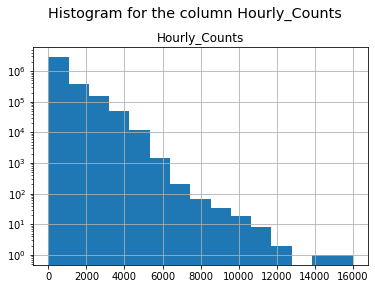

In [77]:
plot_df.hist(bins=15)
plt.yscale('log') #, nonpositive='clip'
plt.suptitle('Histogram for the column Hourly_Counts',x=0.5, y=1.02, fontsize='x-large')

As it can be clearly seen that this plot is right skewed and therefore it does not follow a gaussian distribution. The **Hourly_Counts** values are mostly in the range of 0-6000(approx.) and therefore the partitions for the dataframe should not be done on the basis of the range of the Hourly_Counts column. 

For creating the next plot it will be useful to create two more column in the dataframe:
* MonthNum - The numerical value for the month.
* DayofWeek - Thiscolumn contains the Day of the week as a numerical value.

These column would come handy to order axis/legends in the visualization.

In [78]:
# Creating the column to get the numerical value for the Month
# and day of week for the date
pdstrn_count_spdf = pdstrn_count_spdf.withColumn('MonthNum', month(pdstrn_count_spdf.Date_Time))\
                                    .withColumn('DayofWeek',dayofweek(col("Date_Time")))

In [79]:
# Aggregating the data for Year, Month, MonthNum, Mdate and getting the sum
pdstrn_count_spdf_lp = pdstrn_count_spdf.groupBy(['Year','Month','MonthNum','Mdate']).agg(sum(col('Hourly_Counts'))\
                                          .alias('Total_Counts'))

In [80]:
# Aggregating the data for Month and getting the average
pdstrn_count_spdf_lp = pdstrn_count_spdf_lp.groupBy(['Month','MonthNum']).agg(mean(col('Total_Counts'))\
                                          .alias('Average Daily Count'))\
                                          .orderBy(['MonthNum'])

# Converting the data to Pandas to use it for visualization
pdstrn_count_df_lp = pdstrn_count_spdf_lp.toPandas()

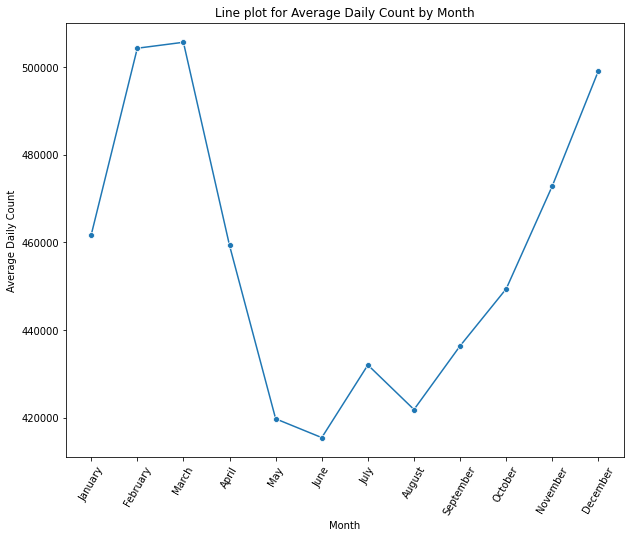

In [81]:
# Setting the plot size
plt.figure(figsize=(10,8))

# Creating line plot using the seaborn package
sns.lineplot(data=pdstrn_count_df_lp, x='Month', y='Average Daily Count', marker="o")\
   .set_title('Line plot for Average Daily Count by Month')

# Rotating the x-axis labels to 60 degree
lplot = plt.xticks(rotation=60)

# plt.suptitle('Line plot for Average Daily Count by Month',x=0.5, y=1.02, fontsize='x-large')

### Observations

Here the observations have been stated according to the above plot:
* The average daily pedestrian counts are the highest in the months February and March.
* After March the average daily pedestrian counts would start decreasing and remain low till August. the reason for this may be that from April a bit of cold winds start and it starts getting slightly colder. It gets a lot colder till August thats why the count remains low.
* After the winters end and Spring starts from September the counts again start rising and rise till December.

## Part 1.2.4 <a class="anchor" name="1.2.4"></a>

Some more plots are required now to get more understanding about the data so that the modelling can be done in a well informed manner. We should try to look at 

In [82]:
# Aggregating the data by Year, Month, Mdate, day, Sensor_Name and getting the sum
agg_day_sensor_df = pdstrn_count_spdf.groupBy(['Year','Month','Mdate','Day','DayofWeek','Sensor_Name'])\
                                     .agg(sum(col('Hourly_Counts'))\
                                     .alias('Total Pedestrian Counts'))

# Aggregating the data by Day, Sensor_Name and getting the mean
# and ordering by DayofWeek in ascending and average pedestrian counts in a descending manner
agg_day_sensor_df = agg_day_sensor_df.groupBy(['Day','DayofWeek','Sensor_Name']).agg(mean(col('Total Pedestrian Counts'))\
                                          .alias('Average Pedestrian Counts'))\
                                          .filter(col('Average Pedestrian Counts') >= 35000)\
                                          .orderBy(col('DayofWeek'),-col('Average Pedestrian Counts'))

# Converting the data into Pandas datafarame to make visualization easier
agg_day_sensor_df = agg_day_sensor_df.toPandas()

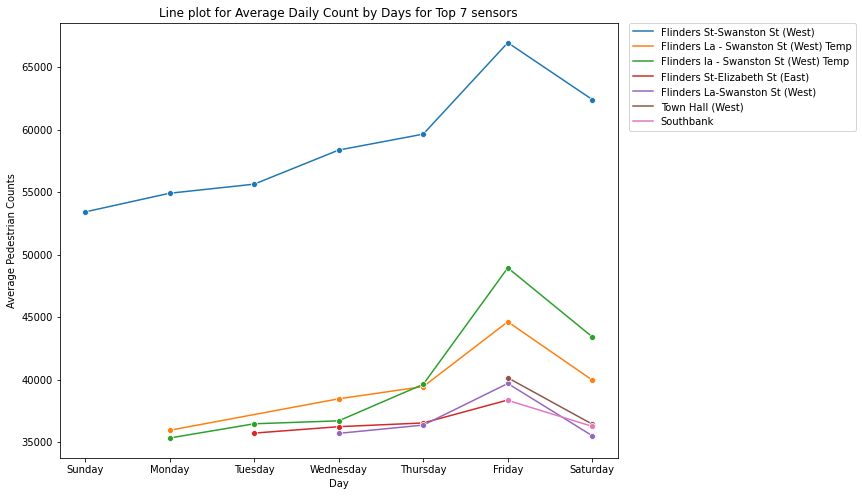

In [83]:
# Setting the plot size
plt.figure(figsize=(10,8))

# Creating line plot using the seaborn package
sns.lineplot(data=agg_day_sensor_df, x='Day', y='Average Pedestrian Counts', marker='o', hue='Sensor_Name', legend='full')\
   .set_title('Line plot for Average Daily Count by Days for Top 7 sensors')

# Reference: https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot
# Code to create the legend outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

### Observations

As the requirement is to arrange performances at the locations it was important to connect the pedestrian counts to the sensor names. The data has been filtered so that only the top 5-6 locations can be plotted to keep the plot clearer. Here the observations have been stated according to the above plot:
* The average pedestrian counts are the highest on Fridays, therefore it would always be profitable to arrange the performances on Fridays.
* The average counts are the highest on the locations(top-3):
    * Flinders St-Swanston St (West)
    * Flinders La - Swanston St (west) Temp
    * Flinders la - Swanston St (west) Temp
* So it is very clear that the location to target for performances on any day would be the Flinders Street and specifically the Swanston Street. On Fridays it would be even more busy than any other day and it would be much profitable for the Street performers.
* On Sundays probably the average pedestrian count is low because may be people take rest/plan their next office day and like to stay more at home.

In [84]:
# Aggregating the data by Date_Time, Time, Sensor_Name and getting the sum
agg_day_time_df = pdstrn_count_spdf.groupBy(['Date_Time','Time','Sensor_Name']).agg(sum(col('Hourly_Counts'))\
                                          .alias('Total Pedestrian Counts'))

# Aggregating the data by Time, Sensor_Name and getting the mean 
# and ordering by average pedestrian counts in a descending manner
agg_day_time_df = agg_day_time_df.groupBy(['Time','Sensor_Name']).agg(mean(col('Total Pedestrian Counts'))\
                                          .alias('Average Pedestrian Counts'))\
                                          .filter(col('Average Pedestrian Counts') >= 2800)\
                                          .orderBy(-col('Average Pedestrian Counts'))

# Converting the data into Pandas datafarame to make visualization easier
agg_day_df = agg_day_time_df.toPandas()

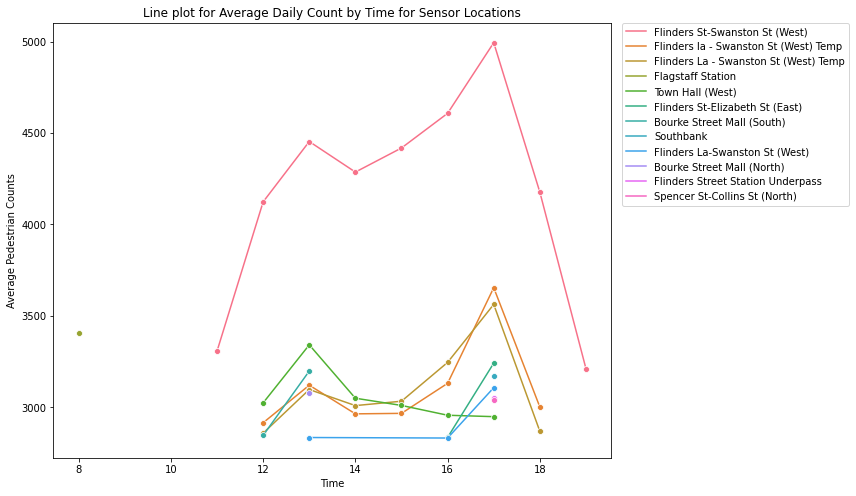

In [85]:
# Setting the plot size
plt.figure(figsize=(10,8))

# Creating line plot using the seaborn package
sns.lineplot(data=agg_day_df, x='Time', y='Average Pedestrian Counts', marker='o', hue='Sensor_Name', legend='full')\
   .set_title('Line plot for Average Daily Count by Time for Sensor Locations')

# Reference: https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot
# Code to create the legend outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

### Observations

As the requirement is to arrange performances at the locations it was important to connect the pedestrian counts to the sensor names. The data has been filtered so that only the top 5-6 locations can be plotted to keep the plot clearer. Here the observations have been stated according to the above plot:
* The average pedestrian counts are the highest in the evenings around 4pm to 5pm after which the average pedestrian count starts decreasing, therefore it would always be profitable to arrange the performances at that time as many pedestrians would be there at that time.
* The average counts(for hourly basis) are the highest on the locations(top-3):
    * Flinders St-Swanston St (West)
    * Flinders La - Swanston St (west) Temp
    * Flinders la - Swanston St (west) Temp
    
* So it is very clear that the location to target for performances at any hour would be the Flinders Street and specifically the Swanston Street.
  
* Performances between the hours 1pm to 5pm would attract the most audience as the average pedestrian count remains high for that period.

## 2. Feature extraction and ML training <a class="anchor" name="two"></a>

In this section, we will need to use PySpark DataFrame functions and ML packages for data
preparation, model building and evaluation. Also it si given that excessive usage of Spark SQL is discouraged.

## 2.1 Discuss the feature selection and prepare the feature columns <a class="anchor" name="2.1"></a>

It can be claerly seen that the data providedis time-series data. We are reuired to create models that use this time-series characteristic of the data to predict the required value. The expectation is to make a one-step prediction.

**One-Step Prediction:** Here we need to predict the pedestrian count value for the next hour using the count and other data for the previous hour.

Also one of the important points is that the prediction needs to be given for hours between **9am and 11pm** both included.

## Part 2.1.1 <a class="anchor" name="2.1.1"></a>

**Column Selection**

1. **ID**: This column is a unique identifier for each row and therefore holds no importance from prediction's standpoint and therefore has been removed well before.
2. **Date_Time**: This column has more importance when it comes to visalization, though it has some information which is present otherwise as well like Year, Month, Date, Time but also has other information which is not present like Day of week, Month Number, etc. It has been used to get this information.
3. **Year, Month, Day, Time**: These column have would prove to be be very helpful for prediction as the exploration that we have seen in **"Question:1.1.3"** and **"Question:1.1.4"**.They look very important as they are showing a good pattern which can be learnt by the machine learning algorithm and hence provide some help with the prediction.
4. **Mdate**: This is not showing that much information therefore it can be removed. The Mdate is a numerical value and if kept The visualization has been done but because of the limit of the graphs it has not been shown.
5. **Sensor_ID**: This feature would also provide a lot of information because there would be some sensors/locations which might always receive high Pedestrian counts and there might be some others which receive low counts. Therefore this feature can show patterns.
6. **Sensor_Name**: This feature does not have any importance as we already have the ID column in the feature list and therefore needs to be removed.
7. **Hourly_Counts**: This column would be present for training the models for regression but will need to be removed for the classification modelling task.
8. **above_threshold**: This column would be present for training the models for classification but will need to be removed for the regression modelling task.
9. **Previous_Hour_Counts**: As it can be seen from the visualizations the Hourly_Counts column can be a very good feature to predict the next value from the previous value and therefore we can use that as a feature for prediction.


<br>

**Transformation**

1. We will have to create the **Previous_Hour_Counts** column from the Hourly_Counts column using the windowing function called **lag()**. We have to window over the **Sensord_ID** column so that the count value of a sensor is not passed to the other sensor while creating a lag.
2. We also need to remove the unwanted data for bettr efficiency. We can filter the data only between 2014 to 2019 and only for hours between 9am to 11pm both inclusive.
3. The columns that will be dropped for the classification model would be: 'Date_Time','MonthNum','DayofWeek','Mdate','Sensor_Name','Hourly_Counts'.
4. The columns to be dropped for the regression model would be: 'Date_Time','MonthNum','DayofWeek','Mdate','Sensor_Name','above_threshold'.
5. We need to convert the datatypes of certain columns to the datatypes we need.
    * Time - StringType()
    * Previous_Hour_Counts - IntegerType()
    * Hourly_Counts - IntegerType()
    * Sensor_ID - StringType()
6. Column name changes:
    * above_threshold - label
    * Houry_Counts - target
7. Next we need to use the **StringIndexer** to index the string column which would be required in the next step.
8. Now the **One-Hot Encoding** can be used for these indexed values so that the model can use these as features and make predictions. These values are being encoded in this manner as their ordinal values would not have any importance and may affect the model negatively.
9. Before using the numeric columns and transformed columns(in point (7) and (8)) we need to assemble them into vectors using **VectorAssembler** so that they can be used by the models.

## Part 2.1.2 <a class="anchor" name="2.1.2"></a>

In this part the transformations and the feature engineering that has been talked about in the previous part will be implemented.

We are creaing a lag on the column Hourly_Counts using the **lag()** function. And als we are using **partitionBy()** function on the Sensor_ID column to make sure that the data from one sensor is not given to the other sensor. Finally we are **orderBy()** function and ordering the data on the basis of the Date_Time column.

In [86]:
# Using the lag() function to create the Previous_Hour_Counts function
# Using partitionBy() funciton to make sure sure that the data from one sensor is not given to the other sensor
# Using orderBy() function and ordering the data using on the basis of the Date_Time column.

modeldata_df = pdstrn_count_spdf.withColumn('Previous_Hour_Counts', lag('Hourly_Counts')\
                                            .over(w.partitionBy('Sensor_ID').orderBy(['Date_Time'])))

So if we are creating lag on the column Hourly_Counts we would be getting null values for each of the sensor Ids as have windowed on the sensor Ids. Therefore, before proceeding we need to remove these null values. This can be done using the **na.drop()** functionality.

In [87]:
# Dropping the rows with null values
modeldata_df = modeldata_df.na.drop()

In [88]:
# Printing the schema to see if the Previous_Hour_Counts has been successfully created
modeldata_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)
 |-- above_threshold: string (nullable = false)
 |-- MonthNum: integer (nullable = true)
 |-- DayofWeek: integer (nullable = true)
 |-- Previous_Hour_Counts: integer (nullable = true)



In [89]:
# Filtering the data using the filter() function
modeldata_df = modeldata_df.filter((modeldata_df.Year >= 2014) & \
                                   (modeldata_df.Year <= 2019) & \
                                   (modeldata_df.Time >= 9) & \
                                   (modeldata_df.Time <= 23))

Now we will drop the columns which are not required for each of the usecases and get the data in another dataframe.

In [90]:
# Dropping the columns not required for classfication usecase
# Creating list of columns to drop
columns_to_drop_for_classification = ['ID','Date_Time','MonthNum','DayofWeek','Mdate','Sensor_Name','Hourly_Counts']

#Using the list to drop the column from the dataframe using the drop function
selected_features_df_cf = modeldata_df.drop(*columns_to_drop_for_classification)



# Dropping the columns which are not required for regression usecase
# Creating list of columns to drop
columns_to_drop_for_regression = ['ID','Date_Time','MonthNum','DayofWeek','Mdate','Sensor_Name','above_threshold']

#Using the list to drop the column from the dataframe using the drop function
selected_features_df_reg = modeldata_df.drop(*columns_to_drop_for_regression)

Let's check the schema of the dataframes created in the last step to make sure that only the required columns are there in them.

In [91]:
selected_features_df_cf.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- above_threshold: string (nullable = false)
 |-- Previous_Hour_Counts: integer (nullable = true)



In [92]:
selected_features_df_reg.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)
 |-- Previous_Hour_Counts: integer (nullable = true)



Next in the flow of transformations comes the datatype conversion in the required datatypes as mentioned in the [Part 2.1.1](#2.1.1)

In [93]:
# Datatype conversion for the classification data dataframe for Time, Previous_Hour_Counts and Sensor_ID columns
# Time - StringType()
# Previous_Hour_Counts - IntegerType()
# Sensor_ID - StringType()
selected_features_df_cf = selected_features_df_cf.withColumn('Time', selected_features_df_cf['Time'].cast(StringType()))\
                                                 .withColumn('Previous_Hour_Counts', \
                                                             selected_features_df_cf['Previous_Hour_Counts']\
                                                             .cast(IntegerType()))\
                                                 .withColumn('Sensor_ID', selected_features_df_cf['Sensor_ID']\
                                                             .cast(StringType()))

# Datatype conversion for the regression data dataframe for Time, Previous_Hour_Counts, Hourly_Counts and Sensor_ID columns
# Time - StringType()
# Previous_Hour_Counts - IntegerType()
# Hourly_Counts - IntegerType()
# Sensor_ID - StringType()
selected_features_df_reg = selected_features_df_reg.withColumn('Time', selected_features_df_reg['Time'].cast(StringType()))\
                                                 .withColumn('Previous_Hour_Counts', \
                                                             selected_features_df_reg['Previous_Hour_Counts']\
                                                             .cast(IntegerType()))\
                                                 .withColumn('Hourly_Counts', \
                                                             selected_features_df_reg['Hourly_Counts']\
                                                             .cast(IntegerType()))\
                                                 .withColumn('Sensor_ID', selected_features_df_reg['Sensor_ID']\
                                                             .cast(StringType()))

In the next step we will also rename the label/target columns for the models that we need to build.
* above_threshold - label
* Houry_Counts - target

In [94]:
selected_features_df_cf = selected_features_df_cf.withColumnRenamed('above_threshold', 'label')
selected_features_df_reg = selected_features_df_reg.withColumnRenamed('Hourly_Counts', 'target')

## 2.2 Preparing Spark ML Transformers/Estimators for features, labels and models <a class="anchor" name="2.2"></a>

In this section of the assigment it is reuqired to use the transformers in-built in the Pyspark module to transform the columns so that they can be used by the model.

## Part 2.2.1 <a class="anchor" name="2.2.1"></a>

The first step to transform the dataframe is to segregate the string and numeric column from both the dataframes and get them in lists so that they can be used accordingly in further steps.

The datatypes of the columns are stored as tuples, these tuples can be accessed and then using the **startswith()** function they can be filtered.

In [95]:
# Getting  the string columns from the classificaiton data dataframe
string_cols_cf = [column[0] for column in selected_features_df_cf.dtypes \
                      if (column[1].startswith('string'))]

# Getting  the integer/numeric columns from the classificaiton data dataframe
int_cols_cf = [column[0] for column in selected_features_df_cf.dtypes \
                      if (column[1].startswith('int'))]

# Getting  the string columns from the regression data dataframe
string_cols_reg = [column[0] for column in selected_features_df_reg.dtypes \
                      if (column[1].startswith('string'))]

# Getting  the integer/numeric columns from the regression data dataframe
int_cols_reg = [column[0] for column in selected_features_df_reg.dtypes \
                      if (column[1].startswith('int'))]

### Transformation for Classification model

For transforming the data for the classification model we need to use the **String Indexer**, **One-Hot Encoder** and **Vector Assembler**. Here we will just create the stages so that these stages can later be plugged in a pipeline to make the code more organised.

In [96]:
##### Stage 1: String Indexer

# Input columns will be the string columns from the classification dataframe
inputCols = string_cols_cf
# output columns will be the column-names with 'str_dex' postfix attached to their original names
outputCols = [f'{x}_str_dex' for x in string_cols_cf]

# First stage of the pipeline for the classification models
# We are using the inputCols parameter to set the input columns and outputCols param to set the output columns
# The handleInvalid param is set to 'keep' so that values outside the splits can be kept in additional buckets
cf_stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols, handleInvalid='keep')



##### Stage 2: One Hot Encoder

# Input columns will be the columns in the outputCols list created in the last step
inputCols_OHE = [x for x in outputCols if x != 'label_str_dex']
# Output columns will be all the string columns except the label column as it has
# been string indexed and need not be encoded using One-Hot encoding
outputCols_OHE = [f'{x}_ohe' for x in string_cols_cf if x != 'label']

# Second stage of the pipeline for the classification models
# We are using the inputCols parameter to set the input columns and outputCols
# param to set the output columns
cf_stage_2 = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)



##### Stage 3: Vector Assembler

# Copying the numeric columns to input columns's list
inputCols_cf = int_cols_cf

# Input columns list being extended with the outputCols_OHE list
inputCols_cf.extend(outputCols_OHE)

# Removing the Year column from the list as it is not
# coming up in the features' importance and therefore
# can be removed
inputCols_cf.remove('Year')

# Third stage of the pipeline for the classification models
# We are using the inputCols parameter to set the input columns and outputCols
# param to set the output columns
cf_stage_3 = VectorAssembler(
    inputCols=inputCols_cf,
    outputCol="features_cf")

### Transformation for Regression model

For transforming the data for the regression model we need to use the **String Indexer**, **One-Hot Encoder** and **Vector Assembler**. Here we will just create the stages so that these stages can later be plugged in a pipeline to make the code more organised.

In [97]:
##### Stage 1: String Indexer

# Input columns will be the string columns from the regression dataframe
inputCols = string_cols_reg
# output columns will be the column-names with 'str_dex' postfix attached to their original names
outputCols = [f'{x}_str_dex' for x in string_cols_reg]

# First stage of the pipeline for the regression models
# We are using the inputCols parameter to set the input columns and outputCols param to set the output columns
# The handleInvalid param is set to 'keep' so that values outside the splits can be kept in additional buckets
reg_stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols, handleInvalid='keep')



##### Stage 2: One Hot Encoder

# Input columns will be the columns in the outputCols list created in the last step
inputCols_OHE = [x for x in outputCols] # if x != 'label_str_dex'
# Output columns will be all the string columns except the label column as it has been string indexed
# and need not be encoded using One-Hot encoding
outputCols_OHE = [f'{x}_ohe' for x in string_cols_reg] #if x != 'label'

# Second stage of the pipeline for the regression models
# We are using the inputCols parameter to set the input columns and outputCols param to set the output columns
reg_stage_2 = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)



##### Stage 3: Vector Assembler

# Copying the numeric columns to input columns's list
inputCols_reg = int_cols_reg

# Input columns list being extended with the outputCols_OHE list
inputCols_reg.extend(outputCols_OHE)

# Removing the Year column from the list as it is not
# coming up in the features' importance and therefore
# can be removed
inputCols_reg.remove('Year')

# Third stage of the pipeline for the regression models
# We are using the inputCols parameter to set the input columns and outputCols
# param to set the output columns
reg_stage_3 = VectorAssembler(
    inputCols=inputCols_reg,
    outputCol="features_reg")

Next we need to create stages for building the models namely:
* Decision Tree for classification
* Decision Tree for regression
* GB Tree for classification
* GB Tree for regression

These stages will the 4th stage for each of the pipelines, i.e. after transforming the data into the required form it will will be used to train these models

In [98]:
# Fourth Stage to include the building of Decision Tree classification model
# Impurity - 'gini' - To use the gini index for splitting the nodes
# maxDepth is kept as 8 because if the value of maxDepth is increased it might lead to over-fitting
# maxBins is kept 40 as  the number of distinct categorical values are more
dt_clsf_stage_4 = DecisionTreeClassifier(featuresCol = 'features_cf', labelCol = 'label_str_dex',
                                       impurity='gini', maxDepth=8, maxBins=40)

In [99]:
# Fourth Stage to include the building of Decision Tree regression model
# Impurity - 'variance' - To perform regression instead of classification
# maxDepth is kept as 5 because if the value of maxDepth is increased it might lead to over-fitting
# maxBins is kept 40 as  the number of distinct categorical values are more
dt_reg_stage_4 = DecisionTreeRegressor(featuresCol = 'features_reg', labelCol = 'target',impurity='variance',\
                                       maxDepth=5, maxBins=40)

In [100]:
# Fourth Stage to include the building of GB Tree classification model
# maxIter - It will go for 5 iterations to get the best model in those 5
#           iterations
gbt_clsf_stage_4 = GBTClassifier(featuresCol = 'features_cf', labelCol = 'label_str_dex', maxIter=5)

In [101]:
# Fourth Stage to include the building of GB Tree regression model
# maxIter - It will go for 10 iterations to get the best model in those 10
#           iterations
gbt_reg_stage_4 = GBTRegressor(featuresCol="features_reg",labelCol = 'target', maxIter=5)

## Part 2.2.2 <a class="anchor" name="2.2.2"></a>

In this section we need to create teo pipelines for each of the usecases to make the code organised, easily manageable.

In [102]:
# This is the pipeline for Decision Tree classification model with all the 4 stages created above
dtcf_pipeline = Pipeline(stages = [cf_stage_1,cf_stage_2,cf_stage_3,dt_clsf_stage_4])

# This is the pipeline for GB Tree classification model with all the 4 stages created above
gbtcf_pipeline = Pipeline(stages = [cf_stage_1,cf_stage_2,cf_stage_3,gbt_clsf_stage_4])

In [103]:
# This is the pipeline for Decision Tree regression model with all the 4 stages created above
dtreg_pipeline = Pipeline(stages = [reg_stage_1,reg_stage_2,reg_stage_3,dt_reg_stage_4])

# This is the pipeline for GB Tree regression model with all the 4 stages created above
gbtreg_pipeline = Pipeline(stages = [reg_stage_1,reg_stage_2,reg_stage_3,gbt_reg_stage_4])

## Part 2.2.3 <a class="anchor" name="2.2.3"></a>

In this section the hyperparameters maxDepth and maxBins for the Decision Tree Machine learning algorithm would be explained.

* **maxDepth**: This is the maximum levels that the programmer wants the tree to go to, the more the number the levels of the tree the more the number of rules will be generated for the data. More the number of levels the more the model moves towards accuracy but with this accuracy comes extra training cost(takes much more time to execute) and over-fitting.
* **maxBins**: With increasing the quantity of maxBins the algorithm's ability to incorporate more split candidates increases and therefore the decisions are taken at a much more granular level. As the granularity of the decisions increases obviously the computation and the communication cost also increases. Note that the maxBins parameter must be at least the maximum number of categories M for any categorical feature.


### According to the usecase
As per the use case as the we are taking the Time and Sensor ID columns as categorical features it would be better to increase the number of bins, as the number of distinct categories are more and therefore this modificaiton in the **maxBins** would increase the ability to incorporate more split candidates.
If the **maxDepth** is kept to a higher value it would lead to over-fitting as the number of features are not a lot.

## 2.3 Preparing the training data and testing data <a class="anchor" name="2.3"></a>

## Part 2.3.1 <a class="anchor" name="2.3.1"></a>

In this section we are required to split the data into training and testing for both the usecases. It is required that the training is done with the data between 2014 and 2018 and the testing data needs to be of the year 2019. Also the complete data needs to be selected except the **Year** column because it has been noted that the Year column does not add any importance to the models, does not improve the model performance and hence will not be included.

First we will create the training and testing data for classification usecase.

In [104]:
# Creating the training data using the dataframe by filtering for the years between 2014 and 2018 both inclusive
# with the selected features - 'Month','Day','Time','Sensor_ID','label','Previous_Hour_Counts'
cf_train_df = selected_features_df_cf.filter((selected_features_df_cf.Year >= 2014) 
                                                   & (selected_features_df_cf.Year <= 2018))\
                                     .select('Month','Day','Time','Sensor_ID','label','Previous_Hour_Counts')


# Creating the testing data using the dataframe by filtering for the year 2019
# with the selected features - 'Month','Day','Time','Sensor_ID','label','Previous_Hour_Counts'
cf_test_df = selected_features_df_cf.filter((selected_features_df_cf.Year == 2019))\
                                    .select('Month','Day','Time','Sensor_ID','label','Previous_Hour_Counts') 

Now we will create the training and testing data for regression usecase.

In [105]:
# Creating the training data using the dataframe by filtering for the years between 2014 and 2018 both inclusive
# with the selected features - 'Month','Day','Time','Sensor_ID','target','Previous_Hour_Counts'
reg_train_df = selected_features_df_reg.filter((selected_features_df_reg.Year >= 2014) 
                                                   & (selected_features_df_reg.Year <= 2018))\
                                     .select('Month','Day','Time','Sensor_ID','target','Previous_Hour_Counts') 


# Creating the training data using the dataframe by filtering for the year 2019
# with the selected features - 'Month','Day','Time','Sensor_ID','target','Previous_Hour_Counts'
reg_test_df = selected_features_df_reg.filter((selected_features_df_reg.Year == 2019))\
                                    .select('Month','Day','Time','Sensor_ID','target','Previous_Hour_Counts') 

Printing the schema of the training and testing dataframes for both the usecases to make sure that they have the required columns.

In [106]:
cf_train_df.printSchema()
cf_test_df.printSchema()
reg_train_df.printSchema()
reg_test_df.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Sensor_ID: string (nullable = true)
 |-- label: string (nullable = false)
 |-- Previous_Hour_Counts: integer (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Sensor_ID: string (nullable = true)
 |-- label: string (nullable = false)
 |-- Previous_Hour_Counts: integer (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Sensor_ID: string (nullable = true)
 |-- target: integer (nullable = true)
 |-- Previous_Hour_Counts: integer (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Sensor_ID: string (nullable = true)
 |-- target: integer (nullable = true)
 |-- Previous_Hour_Counts: integer (nullable = true)



The next step would be to cache the training and testing data for both the usecases as they will be used very often. The caching of the data cab be done using the **cache()** function

In [107]:
# Caching the data for the classification usecase
cf_train_df.cache()
cf_test_df.cache()

DataFrame[Month: string, Day: string, Time: string, Sensor_ID: string, label: string, Previous_Hour_Counts: int]

In [108]:
# Caching the data for the regression usecase
reg_train_df.cache()
reg_test_df.cache()

DataFrame[Month: string, Day: string, Time: string, Sensor_ID: string, target: int, Previous_Hour_Counts: int]

## 2.4 Training and evaluating models <a class="anchor" name="2.4"></a>

## Part 2.4.1 <a class="anchor" name="2.4.1"></a>

In this section we will use the pipeline object for the first usecase. The following steps will be performed in the pipeline:
1. String Indexing of the string columns
2. One-Hot Encoding of the string columns except the label column
3. Vector Assembling of the features so that they can be used by the model
4. Building the Decision Tree/GB Tree classification model.

Next we need to fit the training data on the Decision Tree classification model pipeline.

In [109]:
# Fitting the training data on the Decision Tree classification model pipeline
dtcf_model = dtcf_pipeline.fit(cf_train_df)

# After getting the pipeline model object we can now make predictions
# on the test data
dtcf_Predictions = dtcf_model.transform(cf_test_df)

Now we need to fit the training data on the GB Tree classification model pipeline.

In [110]:
# Fitting the training data on the GB Tree classification model pipeline
gbtcf_model = gbtcf_pipeline.fit(cf_train_df)

# After getting the pipeline model object we can now make predictions
# on the test data
gbtcf_Predictions = gbtcf_model.transform(cf_test_df)

## Part 2.4.2 <a class="anchor" name="2.4.2"></a>

Now it's time to check the predictions for each of the models created

First let's check for the **Decision Tree classification model**

In [111]:
# Displaying the count for ecah of the combinations for actual and predicted value labels
# The column name 'label' becomes 'label_str_dex' after String Indexing
# Also we are ordering it with the precition column to make the display similar
# to the screenshot in the assignment specification
dtcf_Predictions.groupBy('label_str_dex', 'prediction').count().orderBy('prediction').show()

+-------------+----------+------+
|label_str_dex|prediction| count|
+-------------+----------+------+
|          1.0|       0.0|  4391|
|          0.0|       0.0|250290|
|          1.0|       1.0| 26650|
|          0.0|       1.0|  4200|
+-------------+----------+------+



Now let's check for the **GB Tree classification model**

In [112]:
# Displaying the count for ecah of the combinations for actual and predicted value labels
# The column name 'label' becomes 'label_str_dex' after String Indexing
# Also we are ordering it with the precition column to make the display similar
# to the screenshot in the assignment specification
gbtcf_Predictions.groupBy('label_str_dex', 'prediction').count().orderBy('prediction').show()

+-------------+----------+------+
|label_str_dex|prediction| count|
+-------------+----------+------+
|          1.0|       0.0|  4585|
|          0.0|       0.0|248954|
|          1.0|       1.0| 26456|
|          0.0|       1.0|  5536|
+-------------+----------+------+



The above display is called the confusion matrix which is telling us that a lot of values have been predicted properly. But we cannot assess the model like this.We would need to look at metrics like AUC value, Precision value, Recall value and the F1 Score.
For this purpoe a function **compute_metrics_cf()** has been created that computes:
* AUC value
* Accuracy value
* Precision value
* Recall value
* F1 Score

In [113]:
def compute_metrics_cf(predictions, model_name):
    '''
    This function computes the metrics for classification models usde for binary classification.
    There are two params:
    1. predictions: This is the dataframe which contains the predictions done on the test data
                    by the model.
    2. model_name: This id the name of the model that would be used to display.
    '''
    
    
    # True negatives count
    TN = predictions.filter('prediction = 0 AND label_str_dex = 0').count()
    # True positives count
    TP = predictions.filter('prediction = 1 AND label_str_dex = 1').count()
    # False negatives count
    FN = predictions.filter('prediction = 0 AND label_str_dex = 1').count()
    # Fals positives count
    FP = predictions.filter('prediction = 1 AND label_str_dex = 0').count()

    
    # calculating the metrics by the confusion matrix
    # This is the basic accuracy which might not be the right choice for model evaluation
    # as the classes are not balanced
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    
    # This is the percent of true positives predictedtrue positive rate
    precision = TP / (TP + FP)#WRITE CODE : formula to find precision
    
    # This is the 
    recall = TP / (TP + FN)#WRITE CODE : formula to find recall
    
    # This is the harmonic mean of the above computed precision and recall
    f1 = (2 * precision * recall) / (precision + recall)
    
    # Using the BinaryClassificationEvaluator to get the AUC values
    evaluator = BinaryClassificationEvaluator(labelCol='label_str_dex')
    auc_val = evaluator.evaluate(predictions)
    
    # Printing  the metrics for the model
    print(model_name, 'Metrics:\nAUC Value:',\
          str(auc_val) + '\nAccuracy Value:',\
          str(accuracy) + '\nPrecision Value:',\
          str(precision) + '\nRecall Value:',\
          str(recall) + '\nF1 Score:', str(f1) + '\n')

Displaying the evaluation metrics for the Decision Tree classification model using the above created model.

In [114]:
# Code to compute the metrics for the Decision Tree classification model
compute_metrics_cf(dtcf_Predictions,'Decision Tree Model')

Decision Tree Model Metrics:
AUC Value: 0.9345047414781482
Accuracy Value: 0.9699121986754503
Precision Value: 0.8638573743922204
Recall Value: 0.8585419284172546
F1 Score: 0.8611914494837699



Displaying the evaluation metrics for the GB Tree classification model using the above created model.

In [115]:
# Code to compute the metrics for the GB Tree Tree classification model
compute_metrics_cf(gbtcf_Predictions, 'GB Tree Model')

GB Tree Model Metrics:
AUC Value: 0.9859349071254353
Accuracy Value: 0.9645537612378341
Precision Value: 0.8269567391847962
Recall Value: 0.8522921297638607
F1 Score: 0.8394333127092158



Let's discuss the metrics below:
* **Accuracy**: The **accuracy value** though might be fine to compute but as it was discussed at the beginning of the document about the classification problem in this case being an imbalanced one the accuracy value might be misleading. Because if one predicts all the values as below the threshold they still might be 93% percent approx.
* **AUC value**: **AUC value** measures the Area under the ROC Curve. On the ROC curve the TPR(i.e. True positive rate or recall) and the FPR(i.e. False positive rate) are plotted. AUC provides the probability that a positive prediciton will have a higher score than a negative prediction. Therefore it is considrered that more the value of AUC better the model credibility. It measures the ability of the mdel to distinguish between negative and positive class.
* **Precision Value**: This metric provides the proportion of positive values predicted correctly upon the total number of positive class values predicted by the model.
* **Recall Value**: This is the measure that tells us the actual positive class observations that have been predicted as positive by the model.
* **F1 Score**: If we want to use the precision and recall score simultaneously to assess the model its would be better to go with the F1 score as it gives an amalgamated value.

To arrive at a better model the metric that should be chosen are F1 score and AUC value. based on these metrics one can arrive a on a model which will reduce the chance of falsely recommending a location.

The metrics that we need to look at are AUC values and F1 Score:<br><br>
Decision Tree classification model:
* AUC value - 0.9322260860896233
* F1 Score - 0.8548536306191887

GBT Tree classification model:
* AUC value - 0.9869279178574178
* F1 Score - 0.8339677332016755

Out of the metrics for the two models the AUC value for the GB Tree model is greater but the F1 Score of the GB Tree model is lesser than the F1 score of the Decision Tree model. The more preferable value out the two is the F1 score. That is why we are taking the Decision Tree model as the better model. In the next step we will persist the Decision Tree classification model.

In [116]:
dtcf_model.stages[-1].save('agoy0005_DTreeClassificationModel_Above_Threshold_Prediction')

## Part 2.4.3 <a class="anchor" name="2.4.3"></a>

In this section first we have to print the node splitting criteria. This can be done using the **toDebugString** API of the model, but the problem is that it does not represent the rules in a way that others can read it. The features do not have the proper name. So it needs to be made in a proper form therefore, two functions **createFeatureDictionary()** and **printSplittingCrieria()** have been created.

In [117]:
# Reference: https://medium.com/@dipaweshpawar/decoding-decision-tree-in-pyspark-bdd98dcd1ddf
def createFeatureDictionary(predictions, featuresCol):
    '''
    This function creates a dictionary with feature number as key and
    feature name as value. It uses the dataframe in which the features
    for prediction are present after vector assembling and the predicted
    values are present in the prediction column.
    
    The input params:
    1. predictions: The dataframe in which the features for prediction
                    are present after vector assembling and the predicted
                    values are present in the prediction column.
    2. featuresCol: The name of vector assembled feature containing all the
                    features to be used for prediction.
    '''
    
    # Initializing the dictionary
    feature_dict = {}
    
    # Getting the metadata from the predictions dataframe
    metadata_dict = predictions.schema[featuresCol].metadata["ml_attr"]["attrs"]

    # Lopping over the metadata dictionary
    for meta_type, meta_list_dict in metadata_dict.items():
        
        # Looping over feature dictionary
        for m in meta_list_dict:
            # Getting the index value of the feature
            index_val = m['idx']
            # Getting the feature name
            feature_name = m['name']
            # Adding the feature to the dictionary
            feature_dict[index_val] = feature_name
    
    return feature_dict


def printSplittingCrieria(pipeline_model, col_dict):
    '''
    This function modifies the splitting criteria in a more readable manner
    so that general public can read it and make sense of it.
    
    The input params:
    1. pipeline_model: The pipeline model object.
    2. col_dict: This is the feature number mapping to feature name dictionary.
    '''
    
    # Getting the rules' string from the model
    splt_string = pipeline_model.stages[-1].toDebugString
    
    # Splitting the rules' string on every line
    list_str = splt_string.split('\n')
    
    # Initializing a new list
    new_list = []
    
    # Looping over the list of strings list_str
    for str_el in list_str:
        
        # Initializing a new string
        new_str = ''
        
        # Using regex to get the number from string
        f_list = re.findall(r'feature ([0-9]+)', str_el)
        
        # Check if the list is empty or not
        if f_list:
            
            # Converting the number string into integer
            f = int(f_list[0])
        
            # Getting the column name form the dictionary
            col_name = col_dict[f]

            # Substituting the string feature number with the column name
            new_str = re.sub(r'(feature [0-9]+)', col_name, str_el)

            # Adding new line to the string
            new_str = new_str + '\n'
        
        # If the new_str is empty
        if new_str == '':
            # Add new line to the existing line string
            str_el = str_el + '\n'
            # Append it to the list
            new_list.append(str_el)
        
        else:
            # Else append new_str to the new_list 
            new_list.append(new_str)
    
    # Finally from the new_list list object create a string
    crt_str = ''.join(new_list)
    
    return crt_str

# Printing the splitting criteria
print(printSplittingCrieria(dtcf_model,createFeatureDictionary(dtcf_Predictions, 'features_cf')))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_c477e04ddcad, depth=8, numNodes=307, numClasses=3, numFeatures=93
  If (Previous_Hour_Counts <= 2003.5)
   If (Previous_Hour_Counts <= 1363.0)
    If (Previous_Hour_Counts <= 1134.5)
     If (Previous_Hour_Counts <= 959.5)
      If (Sensor_ID_ohe_7 in {0.0})
       If (Previous_Hour_Counts <= 819.5)
        Predict: 0.0
       Else (Previous_Hour_Counts > 819.5)
        If (Sensor_ID_ohe_57 in {0.0})
         Predict: 0.0
        Else (Sensor_ID_ohe_57 not in {0.0})
         If (Time_ohe_12 in {0.0})
          Predict: 0.0
         Else (Time_ohe_12 not in {0.0})
          Predict: 1.0
      Else (Sensor_ID_ohe_7 not in {0.0})
       Predict: 0.0
     Else (Previous_Hour_Counts > 959.5)
      If (Sensor_ID_ohe_57 in {0.0})
       If (Sensor_ID_ohe_9 in {0.0})
        If (Sensor_ID_ohe_7 in {0.0})
         Predict: 0.0
        Else (Sensor_ID_ohe_7 not in {0.0})
         If (Time_ohe_10 in {0.0})
          Predict: 0.0
        

Now we need to display the top-3 features that have been selected by the model. For this we would need to create a **getVariableImportance()** function as coded below.

In [118]:
# Reference: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def getVariableImportance(pipelineModel, predictions, featuresCol,n):
    '''
    This function will display the variable importance for top-n features.
    The input params:
    1. pipelineModel: This is the pipeline model object.
    2. predictions: The dataframe in which the features for prediction
                    are present after vector assembling and the predicted
                    values are present in the prediction column.
    3. featuresCol: The name of vector assembled feature containing all the
                    features to be used for prediction.
    4. n: Number of features required to display.
    '''
    
    # Getting the feature importance for the featureImportances API of the model
    f_imp = pipelineModel.stages[-1].featureImportances
    
    # Initializing the list
    dict_list = []
    for i in predictions.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        # list_extract = list_extract + predictions.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
        dict_list.extend(dtcf_Predictions.schema['features_cf'].metadata["ml_attr"]["attrs"][i])
    
    # Creating the dataframe from the list
    list_df = pd.DataFrame(dict_list)
    
    # Creatinga score column form the feature importance list
    list_df['score'] = list_df['idx'].apply(lambda x: f_imp[x])
    
    
    return(list_df.sort_values('score', ascending = False).head(n))

getVariableImportance(dtcf_model, dtcf_Predictions, 'features_cf',3)

,idx,name,score
0,0,Previous_Hour_Counts,0.801491
28,28,Time_ohe_12,0.043905
30,30,Time_ohe_19,0.013992


## Part 2.4.4 <a class="anchor" name="2.4.4"></a>

In this section some suggestions to improve the model would be given and for two of the techniques the code snippets would be provided:

**Suggestions**
1. **Seasonal Influence**: The pedestrian counts threshold can be influenced by the seasons therefore the seasons can be added in the model. This feature can be created on the basis of months like:
    * December to February - Summer: In the peak of summers the number of pedestrians would be less so the summer season can be divided further into two parts peak summers and non-peak summers.
    * March to May - Autumn: Here the counts would be able to follow the normal trend as the weather would not be showing extreme conditions.
    * June to August - Winter: Just like in summers, in the peak of winters the number of pedestrians would be less so the winter season can be divided further into two parts peak winters and non-peak winters.
    * September to November - Spring: Here the counts would be able to follow the normal trend as the weather would not be showing extreme conditions.
    
    Also some festivals are celebrated as per the seasons and therefore it might show a trend which would definitely help in imporving the predictions. The seasons column can further be used as a categorical column and can be transformed using the StringIndexer and One-Hot Encoding and thencan be assembled with other features using the Vector Assembler.
   
    Code snippets to create the feature:
    
            df = df.withColumn('seasonal_influence', when(col(MonthNum).isin([1,2]), 'PeakSummer')
                                                    .when(col(MonthNum) == 12, 'NonPeakSummer')
                                                    .when(col(MonthNum).isin([7,8]), 'PeakWinter')
                                                    .when(col(MonthNum) == 6, 'NonPeakWinter')
                                                    .when((col(MonthNum) >= 3) & (col(MonthNum) <= 5), 'Autumn')
                                                    .when((col(MonthNum) >= 9) & (col(MonthNum) <= 11), 'Spring')
                                                    .otherwise(None)
                                          )

<br>

2. **Using Cross-Validation**: The cross-validation technique is a very good way to improve the model performance. Through this technique the grid-search can be implemented. Various values for the hyperparameters can be provided after which this technique will work to find the best best model and best hyperparameters.

    Code snippets for cross-validation for Decision Tree Model:<br>
    We would need to import the ParamGridBuilder, CrossValidator, CrossValidatorMode modules. After which a set of parameters can be provided which would be fitted in the model iteratively following which the best parameters would be returned. 
        
        param_grid = (ParamGridBuilder()
                      .addGrid(maxDepth, [2, 5, 10, 20, 30, 50])
                      .addGrid(maxBins, [10, 20, 30, 50, 70, 100])
                      .build())
        
    Further the cross-validator object can be created which would iteratively create the models and return the best model and best params.
        
        dtcv = CrossValidator(estimator = pipeline,
                      estimatorParamMaps = param_grid,
                      evaluator = binaryevaluator,
                      numFolds = 5)
                      
    The only con with the cross-validation technique is that it takes a lot of time to complete and is resource intensive too.

<br>

3. **XGBoost Model**: In this assignment we are using the Gradient Boosting Trees algorithm. There isn't a single model which can be said to be the best but the XGBoost model experimentally has performed very well to predicted binary classification usecases. Therefore, this model can be used in usecase-1 of our assignment. And then further the hyperparameter tuning can be performed to find the best combination. The ways in which it can help in improving the model are:
    * It has in-built regularization which would help in avoidin over-fitting
    * It also has non-greedy tree pruning, etc.

<br>

4. **Blending Models**: As the single models work only in a certain way as the algorithm is static. Therefore, it would really help if we can combine the results from various models. We can combine the resultsin various ways like:
    * We can take mode of the results
    * We can take the mean and then convert them into 0 or 1.
    * We can also take weighted mean if we think a certain model is performing much better than the other models and then convert them into 0 or 1.

## Part 2.4.5 <a class="anchor" name="2.4.5"></a>

In this section we will use the pipeline object for the second usecase. The following steps will be performed in the pipeline:
1. String Indexing of the string columns
2. One-Hot Encoding of the string columns except the label column
3. Vector Assembling of the features so that they can be used by the model
4. Building the Decision Tree/GB Tree regression model.

Next we need to fit the training data on the Decision Tree regression model pipeline.

In [119]:
# Fitting the training data on the Decision Tree Regression model pipeline
dtreg_model = dtreg_pipeline.fit(reg_train_df)

# After getting the pipeline model object we can now make predictions
# on the test data
dtreg_Predictions = dtreg_model.transform(reg_test_df)

Next we need to fit the training data on the GB Tree regression model pipeline.

In [120]:
# Fitting the training data on the GB Tree Regression model pipeline
gbtreg_model = gbtreg_pipeline.fit(reg_train_df)

# After getting the pipeline model object we can now make predictions
# on the test data
gbtreg_Predictions = gbtreg_model.transform(reg_test_df)

## Part 2.4.6 <a class="anchor" name="2.4.6"></a>

In [121]:
def compute_metrics_reg(predictions, model_name):
    
    rmse_obj = RegressionEvaluator(metricName = 'rmse', predictionCol = 'prediction', labelCol = 'target')
    
    rsquared_obj = RegressionEvaluator(metricName = 'r2', predictionCol = 'prediction', labelCol = 'target')
    
    print(model_name, 'Metrics:\nRMSE Score:',\
          str(rmse_obj.evaluate(predictions))+ '\nR-Squared Value:',\
          str(rsquared_obj.evaluate(predictions)))

In [122]:
compute_metrics_reg(dtreg_Predictions, 'Decision Tree Regression Model')

Decision Tree Regression Model Metrics:
RMSE Score: 78.76087968701704
R-Squared Value: 0.991871497961497


In [123]:
compute_metrics_reg(gbtreg_Predictions, 'GB Tree Regression Model')

GB Tree Regression Model Metrics:
RMSE Score: 105.42473998513337
R-Squared Value: 0.9854362075954333


Let's discuss the metrics below:
* **RMSE Score**: The **RMSE Score** score basically measures the difference between the error for each of the predicted and actual value. The formula is given by:

$$RMSE = \sqrt{\frac{\sum_{i=1}^N{(x_i - \hat{x})^2}}{N}}$$

* **R-Squared Value**: **R-Squared Value** is the proportion of the data explained by the model. It is given by:

$$R^2 = 1- \left(\frac{sum\ of\ squares\ of\ residuals}{total\ sum\ of\ squares}\right)$$

To arrive at a better model the metric that should be chosen is RMSE Score because the R-Squared value though works in many cases but is misleading too because its value increases as the number of features increase. Therefore, the better metric to use would be the RMSE score.

The metrics that we need to look at is RMSE Score:<br><br>
Decision Tree regression model:
* RMSE Score - 78.76087968701704

GBT Tree regression model:
* RMSE Score - 105.42473998513337

Out of the metrics for the two models the RMSE Score for the Decision Tree model is lesser than the RMSE Score for the GBT Tree model, which means there is less error in the precition values of the Decision Tree model and hence it is the preferred model. In the next step we will persist the Decision Tree regression model.

**Note: The RMSE scores are subject to change as the algorithms try to find minimumize the cost function and might be able to find different minimas each time.**

In [124]:
dtreg_model.stages[-1].save('agoy0005_DT_RegressionModel_For_Pedestrian_Count_Prediction')

## 3. Comparison <a class="anchor" name="three"></a>

## Part 3.1 <a class="anchor" name="3.1"></a>

In [3]:
from pyspark.ml.clustering import KMeans


customer_df = spark.createDataFrame([
    (0,19,15,39),
    (0,21,15,81), 
    (1,20,16,6),
    (1,23,16,77), 
    (1,31,17,40),
    (1,22,17,76),
    (1,35,18,6), 
    (1,23,18,94),
    (0,64,19,3), 
    (1,30,19,72),
    (0,67,19,14),
    (1,35,19,99), 
    (1,58,20,15)], 
    ['gender', 'age', 'annual_income', 'spending_score']) 

assembler = VectorAssembler(
    inputCols=['gender', 'age', 'annual_income', 'spending_score'], 
    outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(customer_df)) 

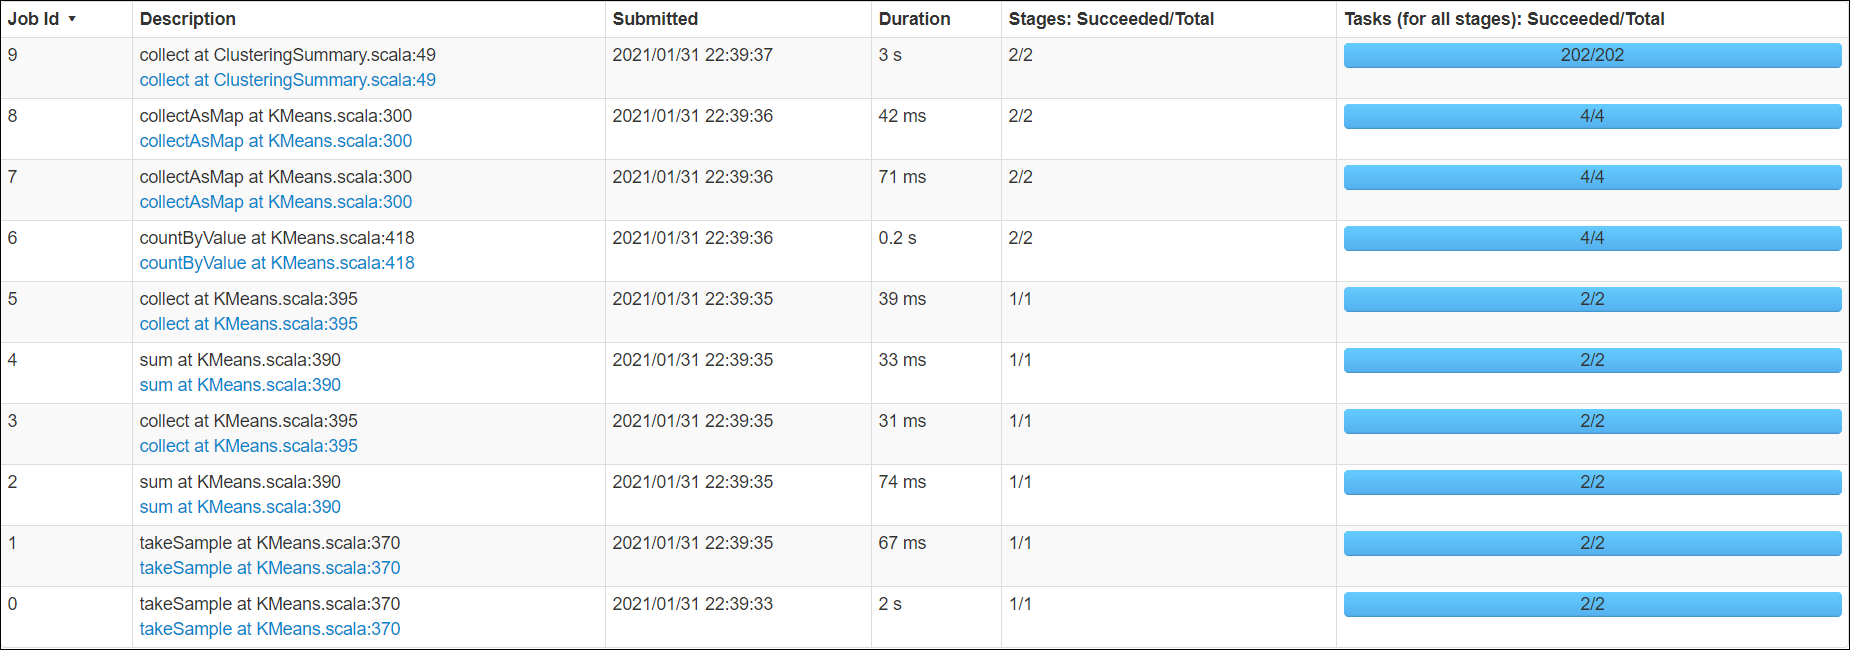

It is evident by the above screenshot that for the given code for **KMeans clustering model** a total of **10 jobs** got executed in spark.

These 10 jobs contain a total of **12 stages**.

There are **2 processors** running on the linux server.

## Part 3.2 <a class="anchor" name="3.2"></a>

## Algorithm Used

### Data Parallelism
After executing the above given code it is requited to carefully go through the steps used to perform clustering. The main steps are the following:
* Partioning the data to be clustered on the two available processors.
* The data is getting mapped and combined(zipped) on an intra-processor basis i.e. inside the processors and not inter-processor basis which is done in case of the result parallelism technique.
* Then the shuffling/reducebykey takes place to merge the clusters obtained from different processors.
* Finally the results/clusters get collected.

The above steps follow the data parallelism technique and hence spark is following data parallelism in this case.

## Cost Comparison between Result and Data Parallelism
* In case of result parallelism the whole of the data is shuffled across processors therefore it might have an overhead in traffic whereas in case of data parallelism only intra-processor data transfer takes place which is much less expensive. In case of data parallelism the distinct centroids are broadcasted which is very light on resource consumption.